# IMAGE DATA PROCESSING OR GENERATION, IN GENERAL
- [Classification resources](https://www.uspto.gov/web/patents/classification/cpc/html/cpc-G06T.html)
- [Data](https://gerdes.fr/saclay/informationRetrieval/patentFiles/G06T.txt.gz)

## 🪐 Authors
- Dana AUBAKIROVA
- Benedicutus Kent RACHMAT


### 0. IMPORTS

Uncomment this line if you don't have the text file 

In [98]:
# !python -m spacy download en_core_web_lg
# !pip install trankit
# !wget https://gerdes.fr/saclay/informationRetrieval/patentFiles/G06T.txt.gz -P texts
# !gzip -d G06T.txt.gz

In [99]:
import spacy
from spacy.tokens import Span
from spacy.tokens import DocBin
from spacy import displacy
from spacy.util import filter_spans
from spacy.matcher import PhraseMatcher
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from trankit import Pipeline
from lib import *

In [100]:
FUNKY_COLOR = "linear-gradient(90deg, #aa9cfc, #fc9ce7)"

### I. EXPLORATORY ANALYSIS

In [129]:
g06t = open('texts/G06T.txt').read().strip()
patent_texts = g06t.split('\n\n')
patent_lines = g06t.split('\n')

# potential terms
many_terms = open('texts/manyterms.lower.txt').read().lower().strip().split('\n')
print("manyterms.lower.txt contains", len(many_terms), 'terms')


print(len(patent_lines), 'paragraphs of patent text')

# large english pre-trained language model
nlp = spacy.load("en_core_web_lg")
shorttext = patent_texts[0][18000:20000]
doc = nlp(shorttext)
displacy.render(doc, style="ent", jupyter=True)

manyterms.lower.txt contains 743274 terms
298995 paragraphs of patent text


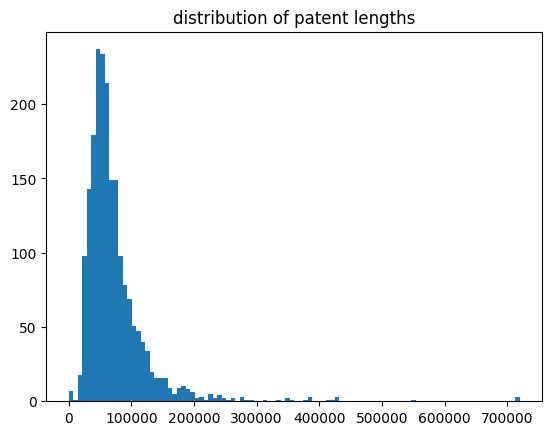

In [130]:
# distribution of patent lengths
patent_lengths = [len(p) for p in patent_texts]
plt.hist(patent_lengths, bins=100)
plt.title("distribution of patent lengths")
plt.show()

Removing the References numbers and the determiners from the text.

In [131]:
num2termlist = rawExtractRefs(shorttext)
print("References numbers and terms:")
display(num2termlist)

References numbers and terms:


{400: ['method'],
 401: ['begins at step'],
 102: ['background data stream'],
 402: ['step'],
 101: ['foreground data stream'],
 403: ['step'],
 404: ['step'],
 100: ['high bit rate stream'],
 406: ['step']}

In [132]:
remove_list = ['r']
exclude_list = ['FIG', 'FIGS']
cleanNshort = removeNumbers(shorttext, num2termlist)
doc = nlp(cleanNshort) 

noun_chunks = get_noun_chunks_v2(doc, remove_list, exclude_list)

displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': "Improved Noun Chunks without determiners"},
                style='ent', options={'colors': {"NC": FUNKY_COLOR}}, manual=True, jupyter=True)

Adding the predicates

In [133]:
doc = nlp(cleanNshort)
displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks_v2(doc, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(doc, noun_chunks)

displacy.render({'text': cleanNshort, 'ents': noun_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": FUNKY_COLOR}})

#### Semantic Graph Representation 

inspired by [Knowledge-Graph-Spacy](https://www.kaggle.com/code/cananserper/knowledge-graph-spacy) 

In [106]:
df = pd.DataFrame({'source': [str(s) for s in sources], 'target': [str(t) for t in targets], 'edge': [r['text'] for r in predicates]})
df.head(10)

,source,target,edge
0,method,variation,is
1,variation,widely known MPEG-DASH standard,of
2,available streams,previous embodiments,to
3,method,step,at
4,step,reception,with
5,reception,subsequent presentation,for
6,subsequent presentation,background data stream,of
7,background data stream,information,on
8,information,information data,present in blending
9,information data,other information,on


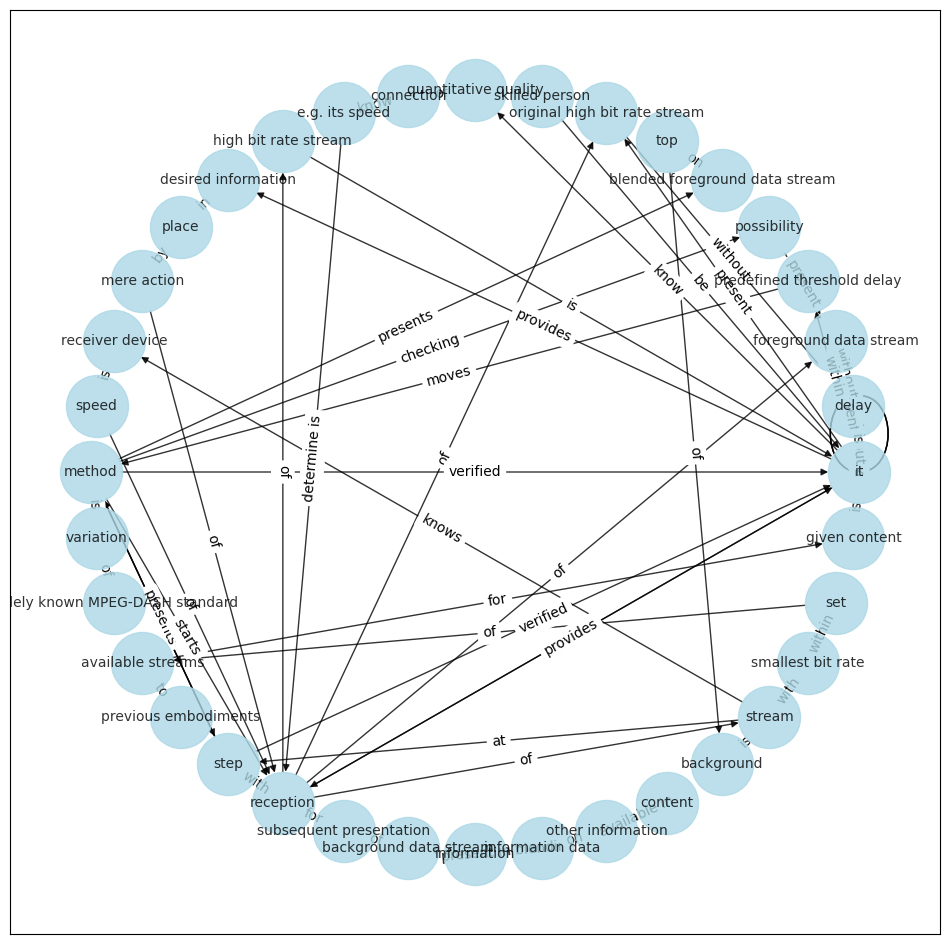

In [107]:
G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.shell_layout(G)
nx.draw_networkx(G, with_labels=True, pos=pos, node_size=2000, node_color='lightblue', edge_color='black', width=1, alpha=0.8, font_size=10)

edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()



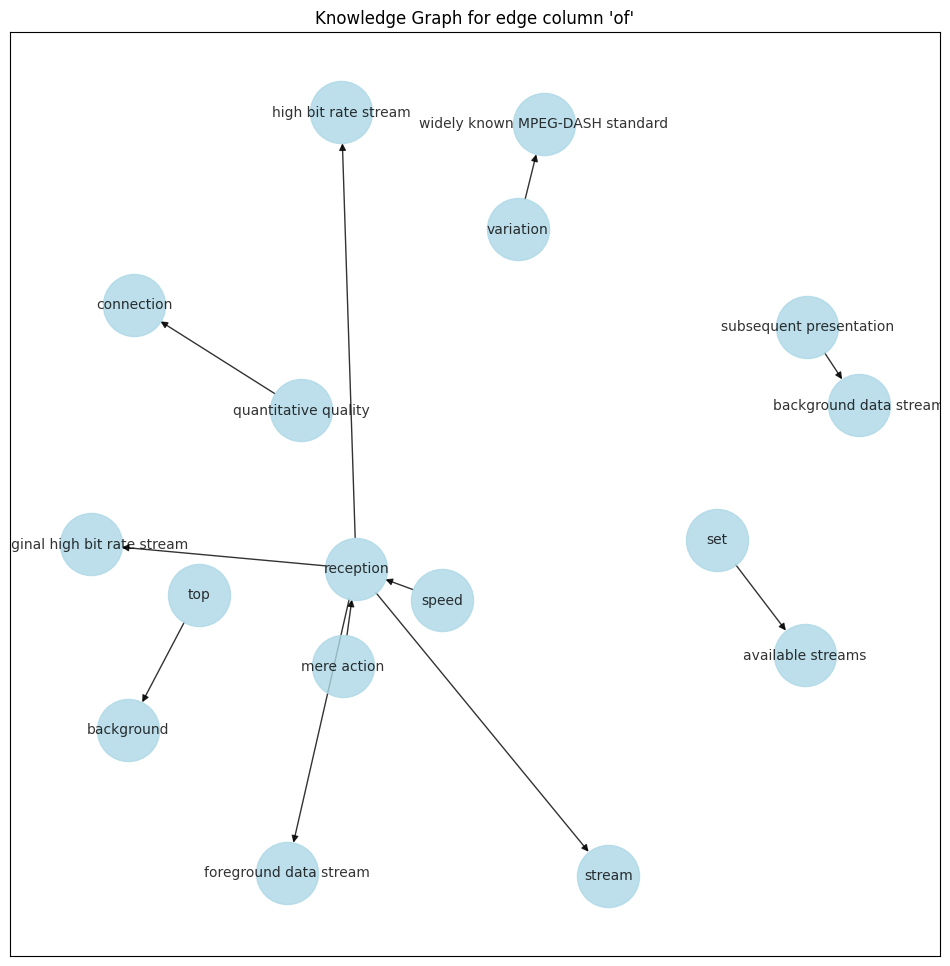

In [108]:
G=nx.from_pandas_edgelist(df[df['edge']=="of"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw_networkx(G, with_labels=True, pos=pos, node_size=2000, node_color='lightblue', edge_color='black', width=1, alpha=0.8, font_size=10)
plt.title("Knowledge Graph for edge column 'of'")
plt.show()

###  II. Spacy

#### ideas
- make a matrix of relations between all NC in a sentence and choose the best ones
- handle coordinations
- ternary relations work?
- better parser: Trankit?
- text preparation to improve results
	- "said"
	- past participles into "that is pp" (no past tense in patents?)
- coreference resolution
- negation
- special treatment for non-connected graphs
- nice inline visualization

In [46]:
cvectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english', vocabulary=many_terms, min_df=500)
X = cvectorizer.fit_transform(patent_lines)
Xdf = pd.DataFrame(np.sum(X, axis=0), columns=cvectorizer.get_feature_names_out()).T.sort_values(by=0, ascending = False)
Xdf.columns = ['count']
Xdf.head(10)

,count
image processing,20995
electronic device,11964
control unit,9676
point cloud,8326
information processing,8074
display device,7039
computer readable,6499
user interface,6342
image sensor,5967
light source,5164


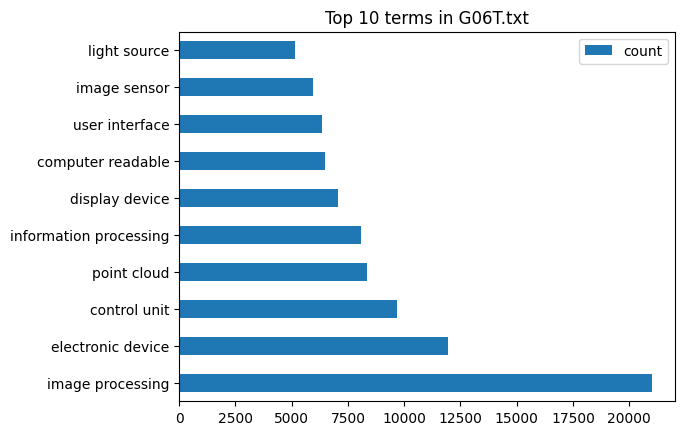

In [47]:
top_10 = Xdf.head(10)
top_10.plot.barh()
plt.title("Top 10 terms in G06T.txt")
plt.show()

In [49]:
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in Xdf.index]
#matcher.add("Tech", patterns)

In [32]:
train_lines, test_lines = train_test_split(patent_lines, test_size=0.3, random_state=42)

In [33]:
def create_dataset(text, n_lines, filename, offset=0):
    LABEL = "TT"
    doc_bin = DocBin()   
    nlp = spacy.blank("en") if (filename == "test_data.spacy") or (filename == "valid_data.spacy") else spacy.load("en_core_web_lg")
    
    for training_example in tqdm(text[offset:offset+n_lines]):
        doc = nlp.make_doc(training_example)
        ents = []

        for match_id, start, end in matcher(doc):
            span = Span(doc, start, end, label=LABEL)
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)

        filtered_ents = filter_spans(ents)
        doc.ents = filtered_ents
        doc_bin.add(doc)

    print("- Saving", len(doc_bin), "documents to", filename)
    doc_bin.to_disk(filename)

In [ ]:
create_dataset(train_lines, 45000, "training_data.spacy")
create_dataset(train_lines, 10000, "valid_data.spacy", 45000)
create_dataset(test_lines, 10000, "test_data.spacy")

In [ ]:
!python -m spacy init fill-config config/base_config.cfg config/config.cfg

In [ ]:
!python -m spacy train config/config.cfg --output ./spacy/spacy_output --paths.train ./spacy/training_data.spacy --paths.dev ./spacy/valid_data.spacy

In [ ]:
nlp_ner = spacy.load("./spacy/spacy_output/model-best")
doc = nlp_ner(shorttext)
spacy.displacy.render(doc, style="ent", jupyter=True)

In [36]:
# Load best model
nlp_ner = spacy.load("./spacy_output_img/model-best")

# Just text snippet
doc = nlp_ner("Web scraping or web data extraction methods are known in the art. Web scraping is used to access the World Wide Web directly using the Hypertext Transfer Protocol, or through a web browser. Web scraping typically refers to automated processes implemented using a bot or web crawler. It is a form of copying, in which specific data is gathered and copied from the web, typically into a central local database or spreadsheet, for later retrieval or analysis.\
Web scraping a web page involves retrieving a predefined Hypertext Markup Language (HTML) page and extracting data from it. Fetching is the downloading of a page which is stored under a static Web address typically specified by a Uniform Resource Locator (URL). Once the page is fetched from where it had been stored, extraction can take place. The content of a page may then be parsed, searched, reformatted, etc. Web scrapers typically extract certain parts of a page to make use \
of it for another purpose. An example is to find and copy names and phone numbers, \
or companies and their URLs, to a list (so-called contact scraping).\
Prior art Web scraping tools can retrieve web page content from pages which are stored as predefined HTML data. Such content is referred to as static content herein because it relates to content provided by static web pages. However, current web technology allows to dynamically generate web pages on a web server in response to requests which may be received from a user or a computer system. As a consequence, data shown on websites can continuously change. A web page containing respective data can change \
its layout and new data fields may be introduced at any time. The content of such dynamic web pages (dynamic content) typically depends on the navigation history through a website. In other words, it depends on where the user currently is and which information and requests have been sent previously.\
 Current Web scraping tools fail to scrape dynamic content data from such dynamically generated web pages and provide respective content data in a machine-readable format so that the content can be further processed by other computer systems provided with the extracted data.\
Summary\
Hence, there is a need for providing improved methods and systems to enable web scraping for dynamic content on dynamic web pages. \
This technical problem is solved by a computer system, a computer-implemented method and a computer program product as disclosed in the independent claims. The disclosed embodiments define a screen-scraping framework which addresses the above problem by automatically connecting to a target website and extracting dynamic data from said target website.\
")

# Show NER results
spacy.displacy.render(doc, style="ent", jupyter=True)

### III. Prodigy

goal
- train spacy models for the extraction of relations
- find alternative
- compare

https://support.prodi.gy/t/beta-testers-wanted-new-manual-dependencies-relations-ui-v1-10/2893

In [33]:
!prodigy


============================ ✨  Available recipes ============================

dep.teach, dep.correct

compare, mark, match, print-dataset, print-stream, review, spacy-config, train,
train-curve, data-to-spacy, stats, drop, db-in, db-out, db-merge, progress

ner.teach, ner.manual, ner.correct, ner.make-gold, ner.silver-to-gold,
ner.eval-ab

textcat.teach, textcat.manual, textcat.correct

pos.teach, pos.correct, pos.make-gold

sent.teach, sent.correct

terms.teach, terms.to-patterns

image.manual

rel.manual

coref.manual

audio.manual, audio.transcribe

spans.manual, spans.correct


In [51]:
!prodigy ner.teach ner_tech  spacy_output_img/model-best  texts/G06T.txt --label TT 

Using 1 label(s): TT
/usr/local/anaconda3/lib/python3.9/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)

✨  Starting the web server at http://localhost:8080 ...
Open the app in your browser and start annotating!

^C


In [ ]:
!prodigy ner.correct gold_tech  ./spacy/spacy_output/model-best  G06T.txt --label TECH_M

In [ ]:
!prodigy ner.silver-to-gold gold_tech ner_tech ./spacy/spacy_output/model-best --label TECH_M 

In [ ]:
!prodigy data-to-spacy ./spacy/prodigy_output --ner gold_tech --eval-split 0.3

In [ ]:
!prodigy train ./spacy/prodigy_output --ner gold_tech --eval-split 0.3 --base-model ./spacy/spacy_output/model-best 

In [ ]:
!prodigy stats ner_tech #--label TECH_M

In [ ]:
nlp_ner = spacy.load("./spacy/prodigy_output/model-best")

colors = {"TECH": "#7DF6D9", "TECH_M": "#7DF6D9"}
options = {"colors": colors} 

for line in test_lines[10000:10010]:
    doc = nlp_ner(line)
    spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

### IV. Relation Detection

#### Predicate detection

In [135]:
def is_predicate(token):
    return token.pos_ in ["VERB", "AUX"]

def get_single_best_predicate(tokens):
    head_tokens = set()
    for token in tokens:
        if is_predicate(token):
            head_tokens.add(token.head)
    best_predicates = [token for token in head_tokens if is_predicate(token)]
    return best_predicates[0] if best_predicates else None

predicates_between_noun_chunks = []

for i in range(len(noun_chunks) - 1):
    start_chunk = noun_chunks[i]
    end_chunk = noun_chunks[i + 1]

    if start_chunk.sent != end_chunk.sent:
        continue

    tokens_between = list(doc[start_chunk.end:end_chunk.start])
    single_best_predicate = get_single_best_predicate(tokens_between)

    if single_best_predicate:
        predicates_between_noun_chunks.append((start_chunk, single_best_predicate, end_chunk))

# Print the results
for start_chunk, single_best_predicate, end_chunk in predicates_between_noun_chunks:
    print(f"{start_chunk} -> {single_best_predicate.text} -> {end_chunk}")


The method -> is -> a variation
The available streams -> assumed -> the previous embodiments
The method -> begins -> step
The background data stream -> retrieved -> information
information data -> retrieved -> other information
The background -> is -> the stream
it -> is -> it
it -> is -> delay
the method -> starts -> reception
The stream -> presented -> this step
it -> verified -> it
it -> verified -> the foreground data stream
the method -> moves -> the possibility
the method -> presents -> a blended foreground data stream
A skilled person -> appreciate -> it
it -> is -> some quantitative quality
the high bit rate stream -> determine -> it
it -> appreciate -> the reception
it -> start -> the desired information
the receiver device -> appreciate -> the speed
The method -> moves -> it
it -> moves -> it
it -> is -> the original high bit rate stream


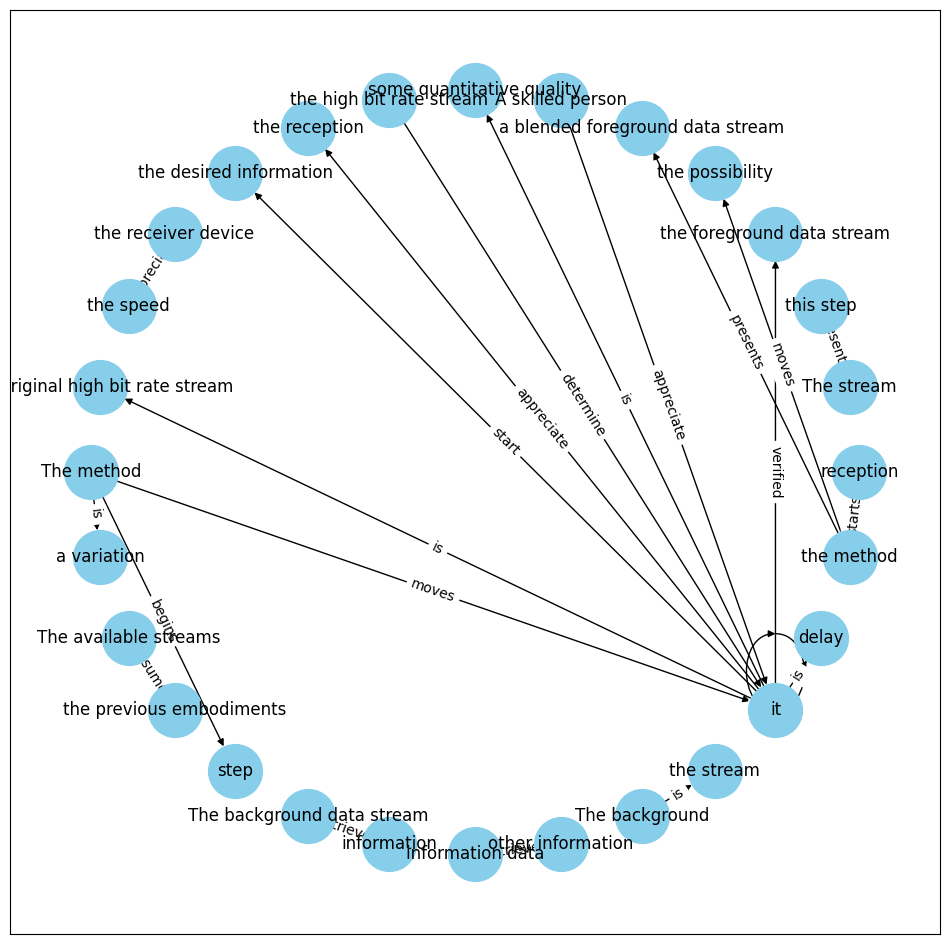

In [158]:
df = pd.DataFrame(predicates_between_noun_chunks, columns=['start_chunk', 'single_best_predicate', 'end_chunk'])
df['start_chunk'] = df['start_chunk'].astype(str)
df['end_chunk'] = df['end_chunk'].astype(str)
df['single_best_predicate'] = df['single_best_predicate'].astype(str)

G = nx.from_pandas_edgelist(df, 'start_chunk', 'end_chunk', edge_attr='single_best_predicate', create_using=nx.DiGraph())
plt.figure(figsize=(12,12))
pos = nx.shell_layout(G)
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'single_best_predicate'))
plt.show()




#### Hyponym and Hypernym

In [171]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")


def hearst_patterns(text):
    patterns = [
        (r"{NP1}<such as>{NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"such {NP1} as {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"{NP1} or other {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"{NP1}, including {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
        (r"{NP1}, especially {NP2}",
         lambda m: (m.group("NP1"), m.group("NP2"))),
    ]

    for pattern, action in patterns:
        for placeholder in ["NP1", "NP2"]:
            pattern = pattern.replace(
                f"{{{placeholder}}}",
                r"(?P<{}>\b(?:\w+\s*)+\b)".format(placeholder),
            )
        regex = re.compile(pattern)
        for match in regex.finditer(text):
            yield action(match)


def extract_hypernyms_hyponyms(text):
    document = nlp(text)
    np_chunks = list(document.noun_chunks)

    np_chunks_text = {str(chunk): chunk for chunk in np_chunks}
    text_with_placeholders = document.text

    for idx, chunk in enumerate(np_chunks):
        text_with_placeholders = text_with_placeholders.replace(
            str(chunk), "{" + str(idx) + "}")

    results = list(hearst_patterns(text_with_placeholders))

    hypernyms_hyponyms = []

    for hypernym, hyponyms in results:
        hypernym_idx = int(hypernym.strip("{}"))
        hypernym = np_chunks[hypernym_idx]
        hyponyms = [np_chunks[int(hyponym.strip("{}"))] for hyponym in hyponyms.split(",")]
        hypernyms_hyponyms.append((hypernym, hyponyms))

    return hypernyms_hyponyms


# Sample usage
sample_text = "Image processing techniques, such as convolutional neural networks and autoencoders, are widely used."
hypernyms_hyponyms = extract_hypernyms_hyponyms(sample_text)

for hypernym, hyponyms in hypernyms_hyponyms:
    print(f"Hypernym: {hypernym}")
    print("Hyponyms:")
    for hyponym in hyponyms:
        print(f"  - {hyponym}")


In [165]:
# # detect co-occurrence of the text
# def get_co_occurrence(text):
#     doc = nlp_ner(text)
#     matcher = Matcher(nlp_ner.vocab)
#     pattern = [{'POS': 'NOUN'}, {'LOWER': 'and'}, {'POS': 'NOUN'}]
#     matcher.add('CoOccurrence', [pattern])
#     matches = matcher(doc)
#     for match_id, start, end in matches:
#         span = doc[start:end]
#         print(span.text)
#         print(span.root.text)
#         print(span.root.head.text)
#         print([child for child in span.root.children])
#         print("")

# get_co_occurrence("A method for detecting a hyponym and a hypernym of a text.")